In [1]:
import pickle

with open('../../PNC_Good/MegaMeta3.pkl', 'rb') as f: 
    meta = pickle.load(f)
    
print('Complete')

Complete


In [2]:
with open('../../Work/LatentSim/Splits.pkl', 'rb') as f:
    keys, groups = pickle.load(f)
    
print(len(keys))
print(len(groups[0][0])+len(groups[0][1]))
print('Complete')

620
620
Complete


In [3]:
import numpy as np

nback = np.stack([meta[key]['nback'] for key in keys])
emoid = np.stack([meta[key]['emoid'] for key in keys])

print(nback.shape)
print(emoid.shape)

(620, 264, 231)
(620, 264, 210)


In [4]:
from nilearn.connectome import ConnectivityMeasure

def getFC(timeSeries, kind='correlation', transpose=True):
    connMeasure = ConnectivityMeasure(kind=kind)
    if transpose:
        timeSeries = np.transpose(timeSeries, axes=(0,2,1))
    return connMeasure.fit_transform(timeSeries)

nback_p = getFC(nback)
emoid_p = getFC(emoid)

print(nback_p.shape)

(620, 264, 264)


In [7]:
import torch

def convertTorch(p):
    t = torch.from_numpy(p).float()
    u = []
    for i in range(t.shape[0]):
        u.append(t[i][torch.triu_indices(264,264,offset=1).unbind()])
    return torch.stack(u).cuda()

nback_p_t = convertTorch(nback_p)
emoid_p_t = convertTorch(emoid_p)

print(nback_p_t.shape)
print(emoid_p_t.shape)
print('Complete')

torch.Size([620, 34716])
torch.Size([620, 34716])
Complete


In [21]:
mu_nback = torch.mean(nback_p_t, dim=0, keepdim=True)
mu_emoid = torch.mean(emoid_p_t, dim=0, keepdim=True)
std_nback = torch.std(nback_p_t, dim=0, keepdim=True)
std_emoid = torch.std(emoid_p_t, dim=0, keepdim=True)

nback_p_t = (nback_p_t - mu_nback)/std_nback
emoid_p_t = (emoid_p_t - mu_emoid)/std_emoid

print(torch.min(nback_p_t[:,420:422],dim=0))
print(torch.min(emoid_p_t[:,420:422],dim=0))

torch.return_types.min(
values=tensor([-2.2998, -3.0133], device='cuda:0'),
indices=tensor([603, 350], device='cuda:0'))
torch.return_types.min(
values=tensor([-2.7284, -3.0616], device='cuda:0'),
indices=tensor([351,  33], device='cuda:0'))


In [8]:
age = np.stack([meta[key]['AgeInMonths'] for key in keys])
gen = np.stack([np.array([meta[key]['Gender'] == 'M', meta[key]['Gender'] == 'F']) for key in keys]).astype(int)
wrt = np.stack([meta[key]['wratStd'] for key in keys])

print(age.shape)
print(gen.shape)
print(wrt.shape)

age_t = torch.from_numpy(age).float().cuda()
gen_t = torch.from_numpy(gen).float().cuda()
wrt_t = torch.from_numpy(wrt).float().cuda()

print('Complete')

(620,)
(620, 2)
(620,)
Complete


In [114]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn.dense import DenseGCNConv

ceLoss = torch.nn.CrossEntropyLoss()
mseLoss = torch.nn.MSELoss()

rmse = []
Ass = []
features = []

def allBelowThresh(losses, thresh):
    for loss,thr in zip(losses, thresh):
        if loss > thr:
            return False
    return True

def flatten(res):
    flat = [r for re in res for r in re]
    return flat

def mask(e):
    return e - torch.diag(torch.diag(e.detach()))

def arith(n):
    return int(n*(n+1)/2)

def getAvg(res):
    nPara = len(res)
    nTasks = len(res[0])
    avg = []
    for task in range(nTasks):
        avg.append(0)
        for para in range(nPara):
            avg[-1] += res[para][task]/nPara
    return avg

class MLP(nn.Module):
    def __init__(self, taskDims, inp, dp=0.5, adp=0.1, dimA=60):
        super(MLP, self).__init__()
        self.nTasks = len(taskDims)
        self.A = []
        self.B = []
        self.C = []
        for para in range(inp.shape[1]):
            A = nn.Linear(inp.shape[2],dimA).float().cuda()
            C = nn.Linear(dimA,inp.shape[2]).float().cuda()
            self.A.append(A)
            self.C.append(C)
            for dim in taskDims:
                head = nn.Linear(dimA,dim).float().cuda().float().cuda()
                self.B.append(head)
        self.A = nn.ModuleList(self.A)
        self.B = nn.ModuleList(self.B)
        self.C = nn.ModuleList(self.C)
        self.dp = nn.Dropout(p=dp)
        self.adp = nn.Dropout(p=adp)
    
    def getLatent(self, x, para):
        return F.relu(self.A[para](x[:,para]).squeeze())
    
    def getB(self, para, task):
        return self.B[para*self.nTasks+task]
    
    def forward(self, x):
        x = self.dp(x)
        res = []
        rec = []
        As = []
        for para in range(2):
            A = self.getLatent(x, para)
            As.append(self.adp(A))
        for para,A in enumerate(As):
            res.append([])
            for task in range(self.nTasks):
                r = self.getB(para,task)(A).squeeze()
                res[-1].append(r)
#             C = self.C[para](A).squeeze()
#             rec.append(C)
        return res, As, rec
    
class GCN(nn.Module):
    def __init__(self, taskDims, inp, dp=0.5, adp=0.1, dimA=60):
        super(GCN, self).__init__()
        self.nTasks = len(taskDims)
        self.A = []
        self.B = []
        self.C = []
        for para in range(inp.shape[1]):
            A = DenseGCNConv(inp.shape[2],dimA).float().cuda()
            C = nn.Linear(dimA,inp.shape[2]).float().cuda()
            self.A.append(A)
            self.C.append(C)
            for dim in taskDims:
                head = DenseGCNConv(dimA,dim).float().cuda().float().cuda()
                self.B.append(head)
        self.A = nn.ModuleList(self.A)
        self.B = nn.ModuleList(self.B)
        self.C = nn.ModuleList(self.C)
        self.dp = nn.Dropout(p=dp)
        self.adp = nn.Dropout(p=adp)
    
    def getLatent(self, x, para, adj):
        return F.relu(self.A[para](x[:,para], adj).squeeze())
    
    def getB(self, para, task):
        return self.B[para*self.nTasks+task]
    
    def forward(self, x):
        x = self.dp(x)
        adj = (torch.ones(x.shape[0], x.shape[0]) - torch.eye(x.shape[0]))/(x.shape[0]-1)**2
        adj = adj.float().cuda()
        res = []
        rec = []
        As = []
        for para in range(2):
            A = self.getLatent(x, para, adj)
            As.append(self.adp(A))
        for para,A in enumerate(As):
            res.append([])
            for task in range(self.nTasks):
                r = self.getB(para,task)(A, adj).squeeze()
                res[-1].append(r)
            C = self.C[para](A).squeeze()
            rec.append(C)
        return res, As, rec

def validate(model, X, ys, testIdcs):
    model.eval()
    losses = []
    with torch.no_grad():
        res, _, _ = model(X)
        # for r,y in zip(res, ys):
        for r,y in zip(getAvg(res), ys):
            if y.dim() == 1:
                loss = mseLoss(r[testIdcs], y[testIdcs]).cpu().numpy()**0.5
                losses.append(loss)
            else:
                corr = (torch.argmax(r, dim=1) == torch.argmax(y, dim=1))[testIdcs]
                loss = torch.sum(corr)/len(testIdcs)
                losses.append(loss)
    model.train()
    return losses

def getAs(model, X):
    model.eval()
    As = None
    with torch.no_grad():
        _, As, _ = model(X)
    model.train()
    return As

def sparseLoss(model, sparseParam):
    loss = []
    for A in model.A:
#         l = sparseParam*(torch.sum(torch.abs(A.lin.weight))+torch.sum(torch.abs(A.bias)))
        l = sparseParam*(torch.sum(torch.abs(A.weight))+torch.sum(torch.abs(A.bias)))
        loss.append(l)
    return loss

def reconLoss(rec, x, reconParam):
    loss = []
    for i,r in enumerate(rec):
        loss.append(reconParam*mseLoss(r, x[:,i]))
    return loss

nEpochs = 20000
pPeriod = 1000
thresh = [20,1e-6,10]
regParam = [0,1e3,5] #[1,1e3,5]
sparseParam = 1e1
reconParam = 0

for rep in range(1):
    for grp in range(10):
        trainIdcs = groups[grp][0][0:496] #496
        trainValidIdcs = groups[grp][0]
        validIdcs = np.arange(496,len(trainValidIdcs))
        testIdcs = groups[grp][1]

        X0 = nback_p_t
        X1 = emoid_p_t

        X = torch.stack([X0, X1], dim=1)
        Xt = X[trainIdcs]
        Xtv = X[trainValidIdcs]

        yy = [age_t, gen_t, wrt_t]
        yt = [age_t[trainIdcs], gen_t[trainIdcs], wrt_t[trainIdcs]]
        ytv = [age_t[trainValidIdcs], gen_t[trainValidIdcs], wrt_t[trainValidIdcs]]

    #     yy = yy[2:]
    #     yt = yt[2:]
    #     ytv = ytv[2:]

        nTasks = len(yy)

        mlp = MLP([1,2,1], X, dp=0.5, adp=0, dimA=100)
        optim = torch.optim.Adam(mlp.parameters(), lr=5e-4, weight_decay=5e-4)

        validLoss = [[] for _ in range(nTasks)]

        for epoch in range(nEpochs):
            optim.zero_grad()
            res, As, rec = mlp(Xt)
            loss = []
            for i,(r,y) in enumerate(zip(flatten(res)+getAvg(res), (X.shape[1]+1)*yt)):
                if y.dim() > 1:
                    loss.append(regParam[i%nTasks]*ceLoss(r, y))
                else:
                    loss.append(regParam[i%nTasks]*mseLoss(r, y))
            bloss = sparseLoss(mlp, sparseParam)
            loss += bloss
            rloss = 0#reconLoss(rec, Xt, reconParam)
#             loss += rloss
            sum(loss).backward()
            optim.step()
            if epoch % pPeriod == 0 or epoch == nEpochs-1 or allBelowThresh(loss[0:nTasks], thresh):
                print(f'epoch {epoch} loss={bloss} {rloss}')
                losses = validate(mlp, Xtv, ytv, validIdcs)
                for i,lss in enumerate(losses):
                    if (len(validLoss[i]) == 0 or 
                            (yy[i].dim() == 1 and lss < min(validLoss[i])) or 
                            (yy[i].dim() > 1 and lss > max(validLoss[i]))):
                        print(f'New best validation epoch {epoch} {i} loss={lss}')
                        torch.save(mlp.state_dict(), f'../../Work/LatentSim/mlp{i}.pyt')
                        validLoss[i].append(float(lss))
                if allBelowThresh(loss[0:nTasks], thresh):
                    print('Early stopping')
                    break

        finalLoss = []

        for task in range(nTasks):
            mlp.load_state_dict(torch.load(f'../../Work/LatentSim/mlp{task}.pyt'))
            loss = validate(mlp, X, yy, testIdcs)
            finalLoss.append(float(loss[task]))

        rmse.append(finalLoss)

        mlp.load_state_dict(torch.load(f'../../Work/LatentSim/mlp2.pyt'))
        for A in getAs(mlp, X):
            A = A.detach()
            w, _, _, _ = torch.linalg.lstsq(A[trainIdcs], age_t[trainIdcs])
            yhat = A[testIdcs]@w
            acc = mseLoss(yhat, age_t[testIdcs])**0.5
            rmse[-1].append(float(acc))
#             A = A.detach().cpu().numpy()
#             y_ = np.argmax(gen[trainIdcs], axis=1)
#             clf = LogisticRegression(max_iter=1000).fit(A[trainIdcs],y_)
#             yhat = clf.predict(A[testIdcs])
#             ytrue = np.argmax(gen[testIdcs], axis=1)
#             acc = np.mean(yhat == ytrue)
#             rmse[-1].append(acc)

        print(f'FINISHED {rmse}')

epoch 0 loss=[tensor(93218.4766, device='cuda:0', grad_fn=<MulBackward0>), tensor(93178.9062, device='cuda:0', grad_fn=<MulBackward0>)] 0
New best validation epoch 0 0 loss=169.4996795654297
New best validation epoch 0 1 loss=0.5483870506286621
New best validation epoch 0 2 loss=101.80908966064453
epoch 1000 loss=[tensor(12239.9434, device='cuda:0', grad_fn=<MulBackward0>), tensor(12020.3691, device='cuda:0', grad_fn=<MulBackward0>)] 0
New best validation epoch 1000 0 loss=169.4521942138672
New best validation epoch 1000 1 loss=0.7258064150810242
New best validation epoch 1000 2 loss=33.97625732421875
epoch 2000 loss=[tensor(8202.5400, device='cuda:0', grad_fn=<MulBackward0>), tensor(8615.6299, device='cuda:0', grad_fn=<MulBackward0>)] 0
New best validation epoch 2000 1 loss=0.7419354915618896
New best validation epoch 2000 2 loss=30.223682403564453
epoch 3000 loss=[tensor(6370.6133, device='cuda:0', grad_fn=<MulBackward0>), tensor(6726.0557, device='cuda:0', grad_fn=<MulBackward0>)] 0

New best validation epoch 0 1 loss=0.596774160861969
New best validation epoch 0 2 loss=98.89140319824219
epoch 1000 loss=[tensor(11770.8389, device='cuda:0', grad_fn=<MulBackward0>), tensor(11882.5273, device='cuda:0', grad_fn=<MulBackward0>)] 0
New best validation epoch 1000 0 loss=173.75807189941406
New best validation epoch 1000 1 loss=0.7419354915618896
New best validation epoch 1000 2 loss=31.402469635009766
epoch 2000 loss=[tensor(7910.0596, device='cuda:0', grad_fn=<MulBackward0>), tensor(8209.8916, device='cuda:0', grad_fn=<MulBackward0>)] 0
New best validation epoch 2000 1 loss=0.774193525314331
New best validation epoch 2000 2 loss=27.440399169921875
epoch 3000 loss=[tensor(6698.5703, device='cuda:0', grad_fn=<MulBackward0>), tensor(6959.9116, device='cuda:0', grad_fn=<MulBackward0>)] 0
New best validation epoch 3000 2 loss=24.196779251098633
epoch 4000 loss=[tensor(5233.7446, device='cuda:0', grad_fn=<MulBackward0>), tensor(5739.6904, device='cuda:0', grad_fn=<MulBackward0>

New best validation epoch 0 1 loss=0.5322580337524414
New best validation epoch 0 2 loss=99.0019302368164
epoch 1000 loss=[tensor(11883.2803, device='cuda:0', grad_fn=<MulBackward0>), tensor(12163.1240, device='cuda:0', grad_fn=<MulBackward0>)] 0
New best validation epoch 1000 0 loss=172.05245971679688
New best validation epoch 1000 1 loss=0.7096773982048035
New best validation epoch 1000 2 loss=29.88008689880371
epoch 2000 loss=[tensor(7789.0967, device='cuda:0', grad_fn=<MulBackward0>), tensor(8145.8350, device='cuda:0', grad_fn=<MulBackward0>)] 0
New best validation epoch 2000 1 loss=0.7258064150810242
New best validation epoch 2000 2 loss=26.014404296875
epoch 3000 loss=[tensor(6256.5581, device='cuda:0', grad_fn=<MulBackward0>), tensor(6398.2622, device='cuda:0', grad_fn=<MulBackward0>)] 0
New best validation epoch 3000 1 loss=0.7580645084381104
New best validation epoch 3000 2 loss=22.755826950073242
epoch 4000 loss=[tensor(5463.1401, device='cuda:0', grad_fn=<MulBackward0>), ten

epoch 19000 loss=[tensor(2690.1550, device='cuda:0', grad_fn=<MulBackward0>), tensor(2694.7476, device='cuda:0', grad_fn=<MulBackward0>)] 0
epoch 19999 loss=[tensor(2729.8098, device='cuda:0', grad_fn=<MulBackward0>), tensor(2619.9644, device='cuda:0', grad_fn=<MulBackward0>)] 0
FINISHED [[187.13587951660156, 0.8548386693000793, 11.89074420928955, 35.91255569458008, 38.94298553466797], [180.2674560546875, 0.8064515590667725, 14.029871940612793, 36.537052154541016, 41.98127365112305], [182.8394317626953, 0.8225806355476379, 12.84100341796875, 33.40056228637695, 33.19950866699219], [176.60589599609375, 0.7580645084381104, 15.562033653259277, 32.25153350830078, 35.016761779785156], [190.5818634033203, 0.8064515590667725, 13.515454292297363, 36.928977966308594, 37.399200439453125], [179.15267944335938, 0.8225806355476379, 15.37215518951416, 34.2853889465332, 34.62868881225586]]
epoch 0 loss=[tensor(93119.5312, device='cuda:0', grad_fn=<MulBackward0>), tensor(93199.7188, device='cuda:0', gr

New best validation epoch 11000 2 loss=12.150927543640137
epoch 12000 loss=[tensor(2848.2507, device='cuda:0', grad_fn=<MulBackward0>), tensor(2821.7271, device='cuda:0', grad_fn=<MulBackward0>)] 0
New best validation epoch 12000 1 loss=0.8387096524238586
epoch 13000 loss=[tensor(3105.5505, device='cuda:0', grad_fn=<MulBackward0>), tensor(3036.9836, device='cuda:0', grad_fn=<MulBackward0>)] 0
epoch 14000 loss=[tensor(3037.6152, device='cuda:0', grad_fn=<MulBackward0>), tensor(3252.1123, device='cuda:0', grad_fn=<MulBackward0>)] 0
epoch 15000 loss=[tensor(3018.5266, device='cuda:0', grad_fn=<MulBackward0>), tensor(2877.0337, device='cuda:0', grad_fn=<MulBackward0>)] 0
epoch 16000 loss=[tensor(3367.3018, device='cuda:0', grad_fn=<MulBackward0>), tensor(3284.3887, device='cuda:0', grad_fn=<MulBackward0>)] 0
epoch 17000 loss=[tensor(3103.6187, device='cuda:0', grad_fn=<MulBackward0>), tensor(2995.0767, device='cuda:0', grad_fn=<MulBackward0>)] 0
epoch 18000 loss=[tensor(2829.5317, device='

epoch 3000 loss=[tensor(6698.6597, device='cuda:0', grad_fn=<MulBackward0>), tensor(6229.4795, device='cuda:0', grad_fn=<MulBackward0>)] 0
New best validation epoch 3000 2 loss=25.30912971496582
epoch 4000 loss=[tensor(5651.7554, device='cuda:0', grad_fn=<MulBackward0>), tensor(5154.0337, device='cuda:0', grad_fn=<MulBackward0>)] 0
New best validation epoch 4000 2 loss=22.74122428894043
epoch 5000 loss=[tensor(4831.2671, device='cuda:0', grad_fn=<MulBackward0>), tensor(4388.1895, device='cuda:0', grad_fn=<MulBackward0>)] 0
New best validation epoch 5000 1 loss=0.7903225421905518
New best validation epoch 5000 2 loss=20.272842407226562
epoch 6000 loss=[tensor(4371.1309, device='cuda:0', grad_fn=<MulBackward0>), tensor(4126.9355, device='cuda:0', grad_fn=<MulBackward0>)] 0
New best validation epoch 6000 2 loss=18.20355987548828
epoch 7000 loss=[tensor(3729.1565, device='cuda:0', grad_fn=<MulBackward0>), tensor(3587.8379, device='cuda:0', grad_fn=<MulBackward0>)] 0
New best validation epo

In [116]:
print(sum([f[0] for f in rmse])/len(rmse)/12)
print(sum([f[1] for f in rmse])/len(rmse))
print(sum([f[2] for f in rmse])/len(rmse))
print(sum([f[3] for f in rmse])/len(rmse)/12)
print(sum([f[4] for f in rmse])/len(rmse)/12)

15.33691126505534
0.79838707447052
14.576610565185547
3.006328773498535
3.098818016052246


In [108]:
As = getAs(mlp, X)
As = [A.detach() for A in As]

w, _, _, _ = torch.linalg.lstsq(As[0][trainIdcs], wrt_t[trainIdcs])
yhat = As[0][testIdcs]@w
print(mseLoss(yhat, wrt_t[testIdcs])**0.5)

tensor(14.0792, device='cuda:0')


In [101]:
from sklearn.linear_model import LogisticRegression

def getAs(model, X):
    model.eval()
    As = None
    with torch.no_grad():
        _, As, _ = model(X)
    model.train()
    return As

As = getAs(mlp, X)
As = [A.detach() for A in As]

A = As[0].cpu().numpy()
y_ = np.argmax(gen[trainIdcs], axis=1)
clf = LogisticRegression(max_iter=1000).fit(A[trainIdcs],y_)
yhat = clf.predict(A[testIdcs])
ytrue = np.argmax(gen[testIdcs], axis=1)
acc = np.sum(yhat == ytrue)/62
print(acc)

0.45161290322580644


In [70]:
mlp.eval()
recon = None
with torch.no_grad():
    _, _, recon = mlp(X[testIdcs])
mlp.train()

print(recon[0].shape)

torch.Size([62, 34716])


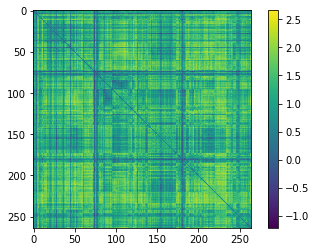

In [72]:
import matplotlib.pyplot as plt
import numpy as np

def toImage(x, a, b, idcs):
    img = np.zeros((264,264))
    img[a[idcs],b[idcs]] = x[idcs]
    img = img + img.T
    return img

a,b = np.triu_indices(264,1)
idcs = np.arange(34716)

img = toImage(recon[1][0].detach().cpu().numpy(), a, b, idcs)
plt.imshow(img)
plt.colorbar()
plt.show()

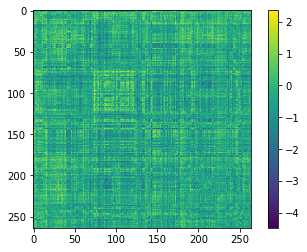

In [73]:
img = toImage(X[0,1].detach().cpu().numpy(), a, b, idcs)
plt.imshow(img)
plt.colorbar()
plt.show()

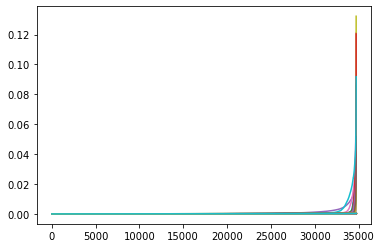

In [77]:
import matplotlib.pyplot as plt

w = mlp.A[0].weight.detach().cpu().numpy()

for dim in range(w.shape[0]):
    plt.plot(np.sort(np.abs(w[dim,:])))
# plt.plot(np.sort(np.sum(np.abs(w), axis=0)))
plt.show()

In [78]:
ww = np.sum(np.abs(w), axis=0)
idcs = np.argsort(ww)
a,b = np.triu_indices(264,1)

for i in idcs[-10::1]:
    print(a[i],b[i],ww[i])

117 177 0.11471606
48 65 0.117774144
11 138 0.12837481
174 217 0.12971546
174 186 0.13033049
153 259 0.13081925
6 89 0.14835572
0 197 0.15533629
92 94 0.16632831
31 257 0.18796518


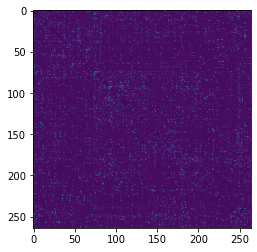

In [79]:
img = np.zeros((264,264))
img[a[idcs],b[idcs]] = ww[idcs]
img = img + img.T

plt.imshow(img)
plt.show()

0.0037181024


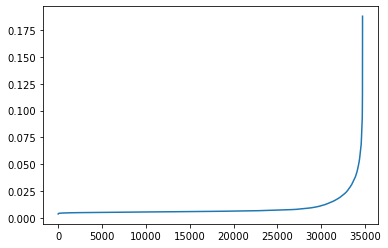

In [80]:
res = np.sort(np.sum(np.abs(w), axis=0))
print(res[0])
plt.plot(res)
plt.show()

In [86]:
tsum = torch.sum(torch.abs(mlp.A[0].weight) > 0.01, dim=1)
tidcs = torch.argsort(tsum, descending=True)
print(np.sum(np.abs(w[tidcs[0:15].detach().cpu().numpy()]), axis=1))
print(torch.sum(tsum > 0))
print(tidcs[0:20])
print(tsum[tidcs[0:20]])

[30.869068  26.111752  18.567629  11.817688  12.062836   8.845172
  6.894711   4.760422   3.9942584  4.5169306  4.784694   3.849507
  3.0014398  3.657267   2.3701298]
tensor(15, device='cuda:0')
tensor([89, 14, 26, 10, 83, 62, 84, 32, 69, 64, 12, 85, 77, 78,  5, 97, 94, 92,
        95, 90], device='cuda:0')
tensor([914, 532, 498, 311, 251, 225, 163,  92,  69,  69,  68,  60,  39,  34,
         22,   0,   0,   0,   0,   0], device='cuda:0')


In [246]:
ww = np.abs(mlp.A[0].weight[18].detach().cpu().numpy())
idcs = np.argsort(ww)
a,b = np.triu_indices(264,1)

for i in idcs[-10::1]:
    print(a[i],b[i],ww[i])

57 64 0.01704379
24 202 0.017224696
144 217 0.018734667
242 244 0.02174334
244 245 0.024713686
47 156 0.030718943
19 73 0.032387853
64 155 0.032578215
64 84 0.0345553
62 64 0.058028284


In [254]:
idcs = torch.argsort(torch.abs(mlp.B[0].weight), descending=True)
print(idcs[0:10])
print(mlp.B[0].weight[idcs[0:10]])

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.